This notebook provides a short sample on how to evaluate your trained model. We will continue from our previous notebook `03_` which has trained a working MLP. 

The complete evaluation script can be found in the root directory of the repository `eval.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import yaml
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
pl.seed_everything(42)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_theme(context='paper')

import sys
sys.path.append('..')

from chaosbench import dataset, config, utils, criterion
from chaosbench.models import model, mlp, cnn, ae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[rank: 0] Global seed set to 42
/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overall benchmark

First, we plot across centers + unet

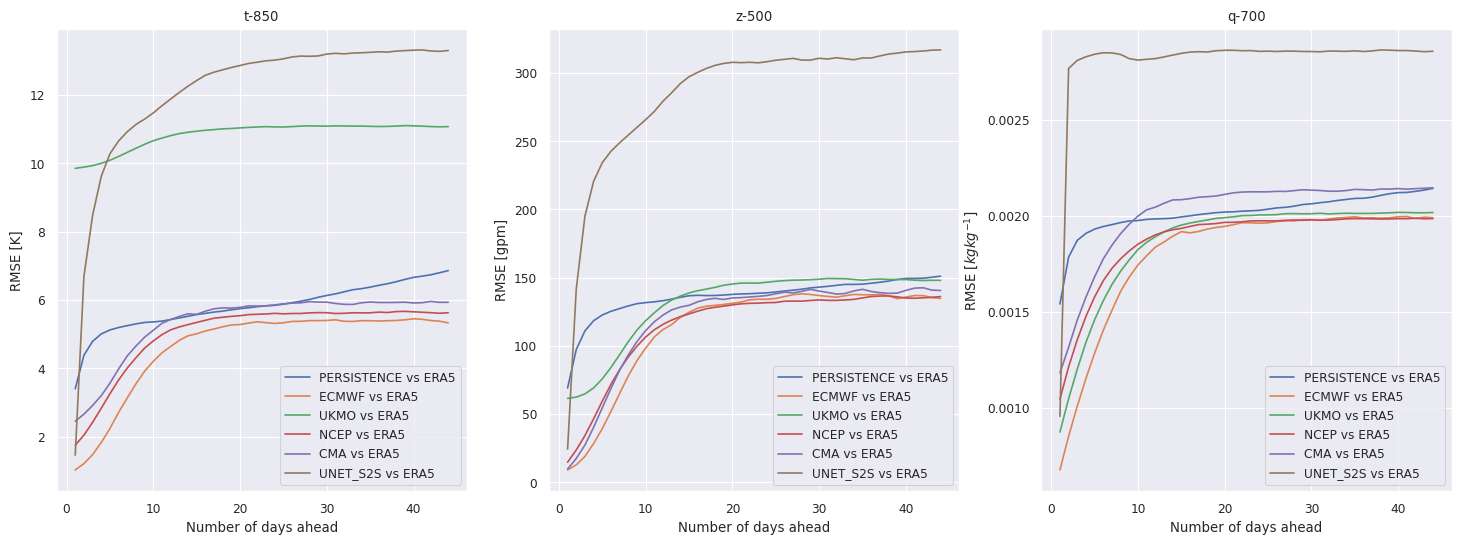

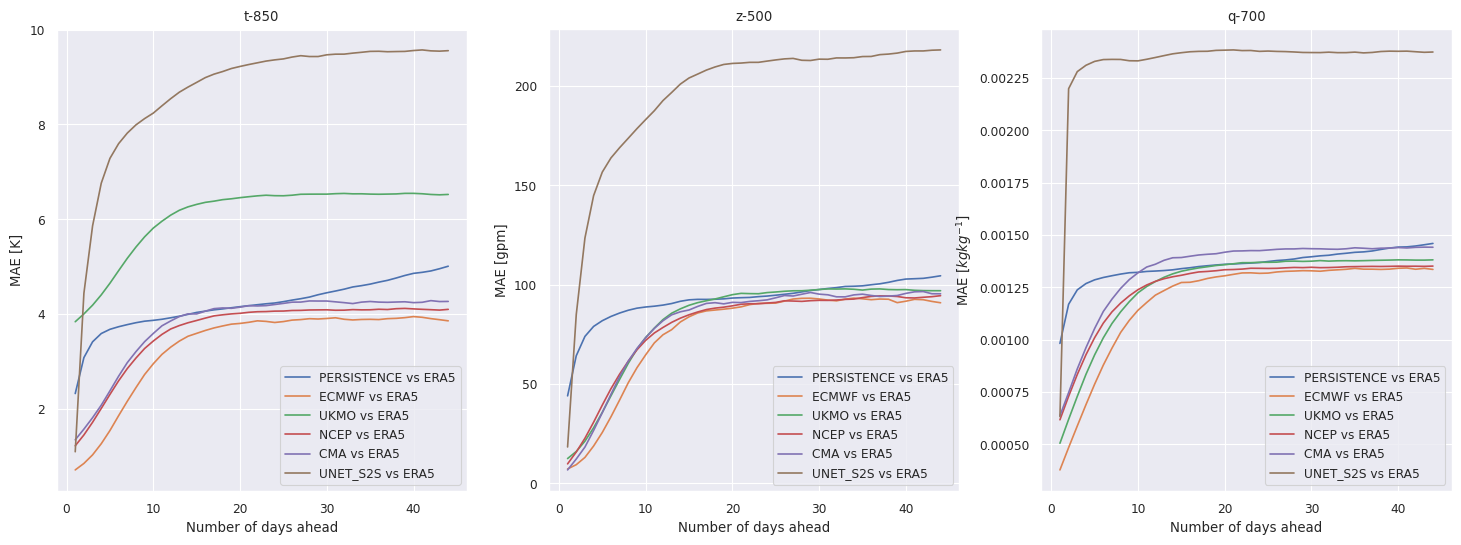

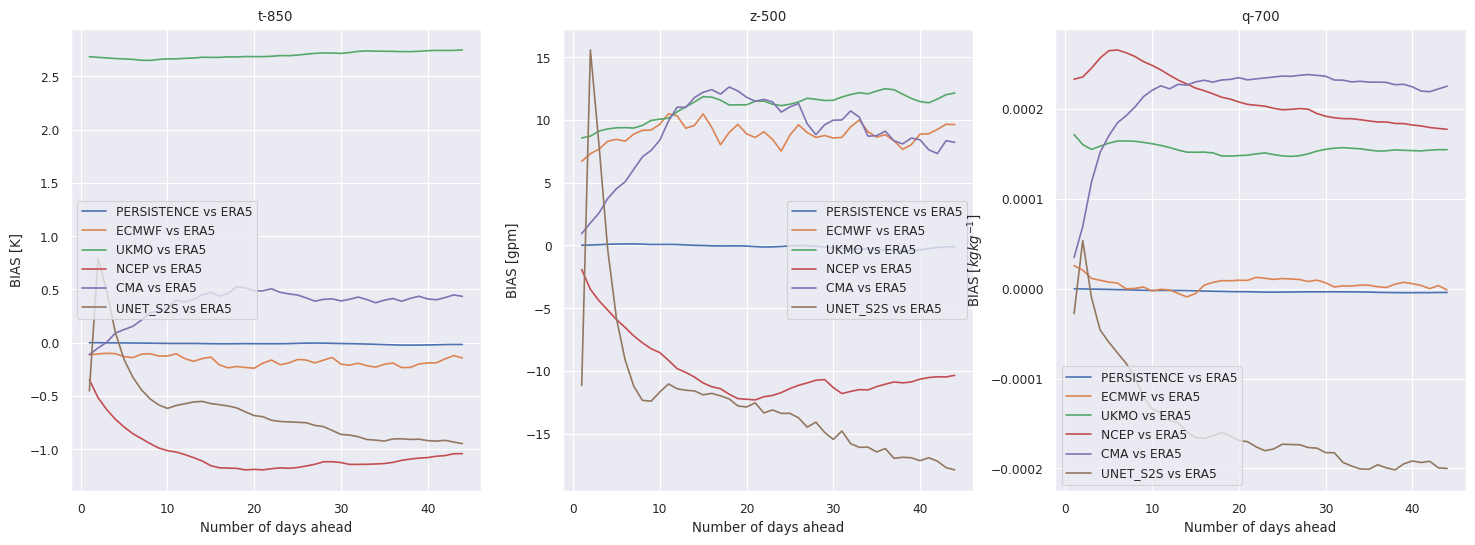

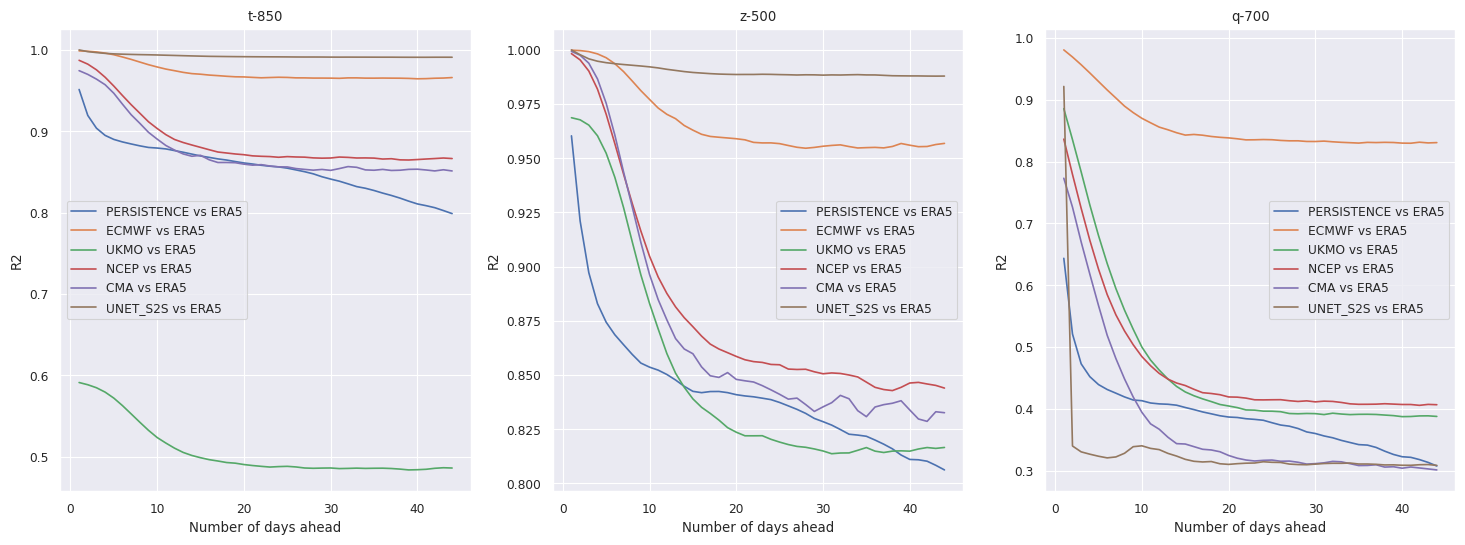

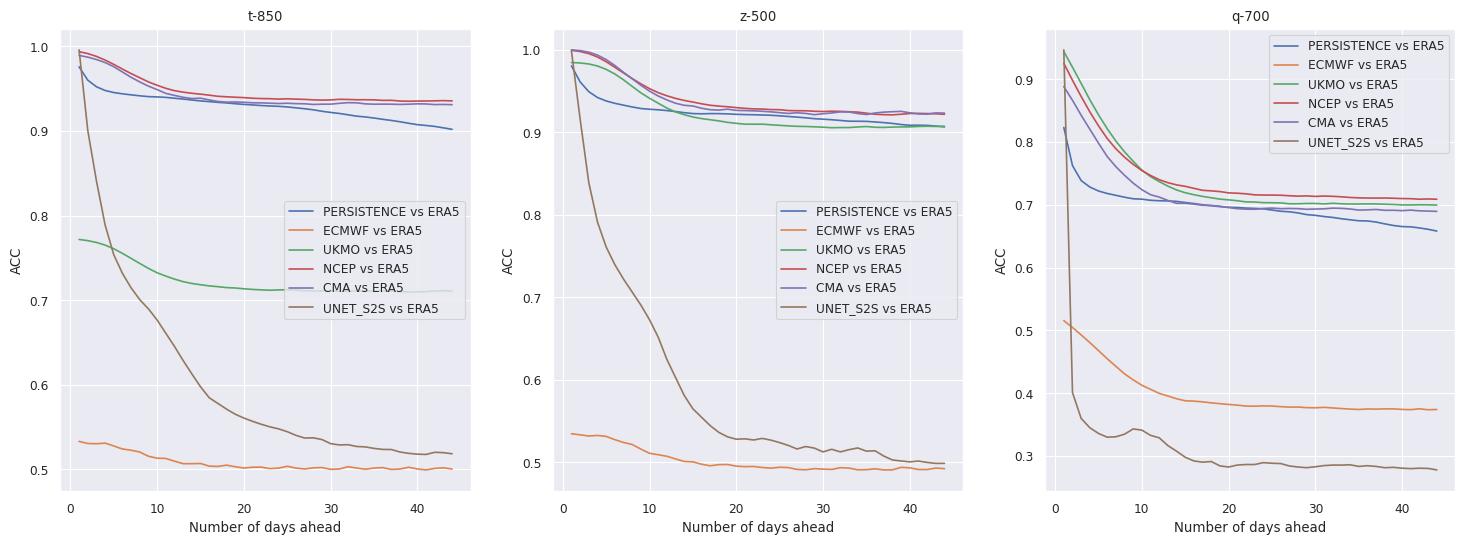

In [3]:
# Plot RMSE over time, across centers
model_names = ['persistence', 'ecmwf', 'ukmo', 'ncep', 'cma', 'unet_s2s']
metrics = ['rmse', 'mae', 'bias', 'r2', 'acc']
headline_vars = dict({'t-850': 'K', 'z-500': 'gpm', 'q-700': r'$kg kg^{-1}$'})

for metric_idx, metric in enumerate(metrics):
    f, ax = plt.subplots(1, len(headline_vars), figsize=(6*len(headline_vars), 6))
    
    for model_idx, model_name in enumerate(model_names):
        if 's2s' in model_name:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/version_3/{metric}_{model_name}.csv'))
        
        else:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            sns.lineplot(
                x=np.arange(1, df.shape[0]+1),
                y=df[[headline_var]].to_numpy().squeeze(), 
                label=f'{model_name.upper()} vs ERA5',
                ax=ax[headline_idx]
            )
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            
            if metric in ['r2', 'acc']:
                ax[headline_idx].set_ylabel(f'{metric.upper()}')
            
            else:
                ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
            
            ax[headline_idx].set_title(f'{headline_var}')

Then we evaluate only on data-driven models (with persistence + ecmwf as benchmark)

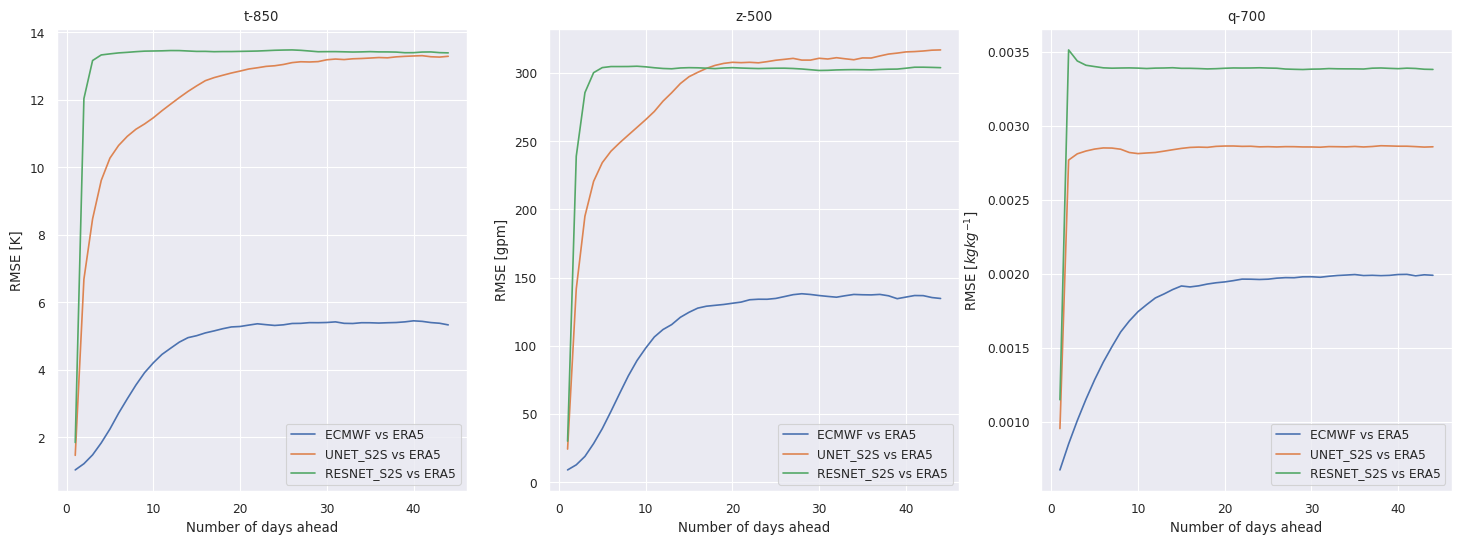

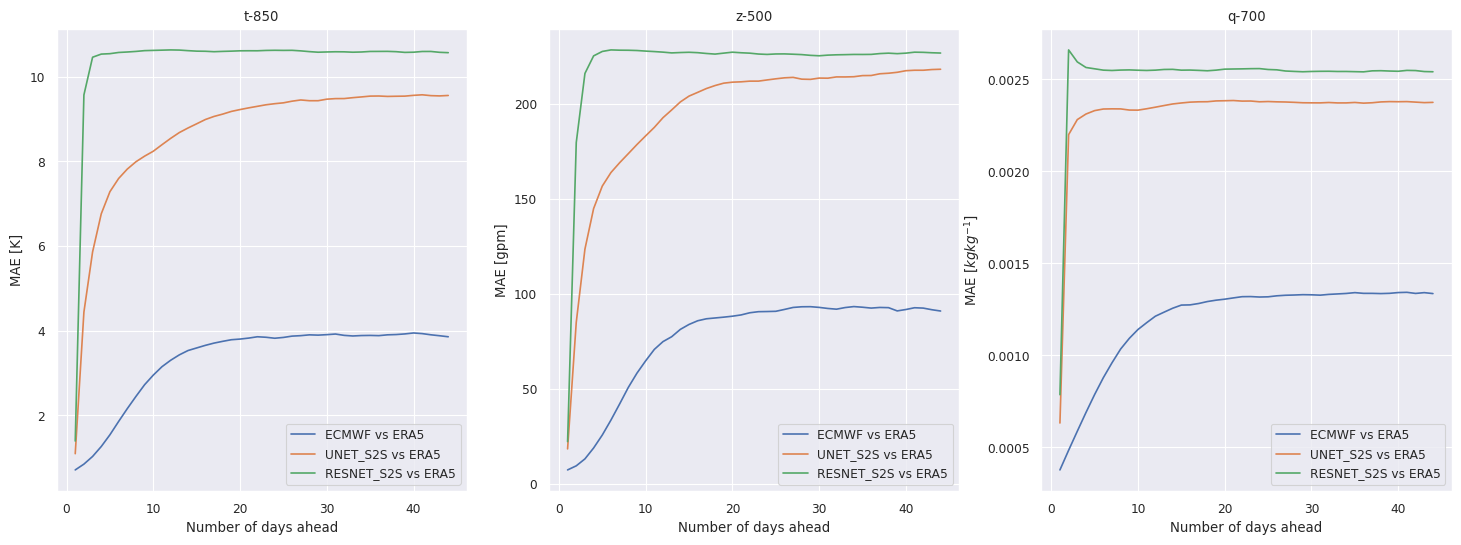

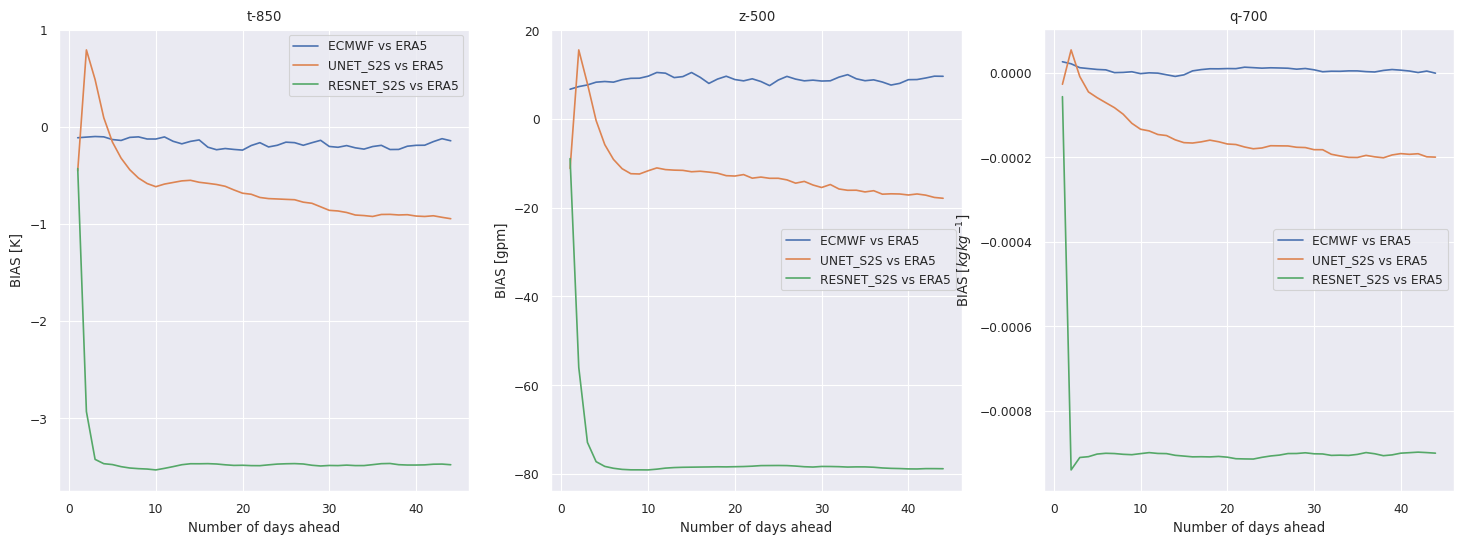

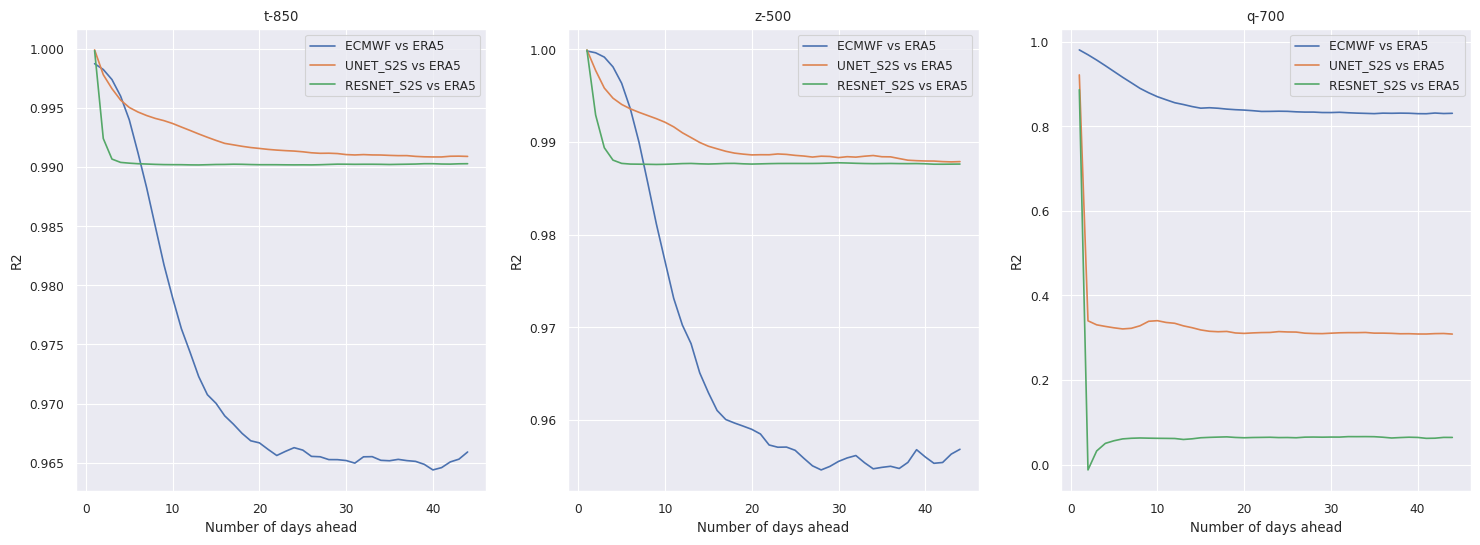

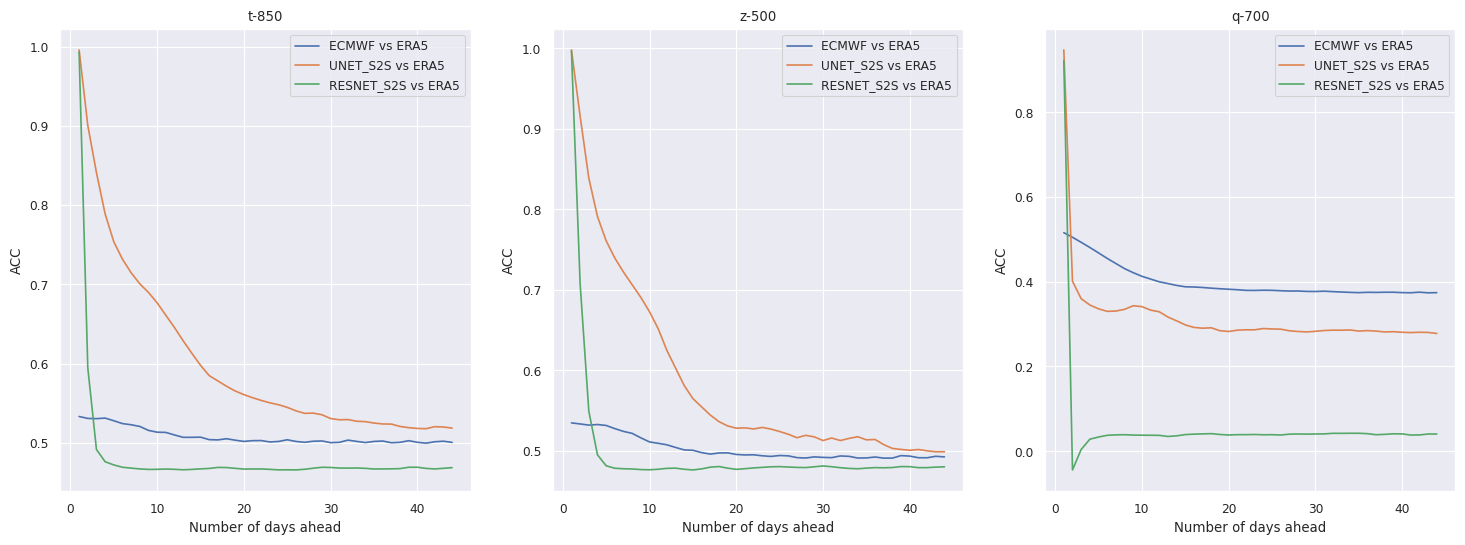

In [4]:
# Plot RMSE over time, across centers and data-driven models
model_names = ['ecmwf', 'unet_s2s', 'resnet_s2s']

for metric_idx, metric in enumerate(metrics):
    f, ax = plt.subplots(1, len(headline_vars), figsize=(6*len(headline_vars), 6))
    
    for model_idx, model_name in enumerate(model_names):
        if 's2s' in model_name:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/version_3/{metric}_{model_name}.csv'))
        
        else:
            df = pd.read_csv(Path(f'../logs/{model_name}/eval/{metric}_{model_name}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            sns.lineplot(
                x=np.arange(1, df.shape[0]+1),
                y=df[[headline_var]].to_numpy().squeeze(), 
                label=f'{model_name.upper()} vs ERA5',
                ax=ax[headline_idx]
            )
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            
            if metric in ['r2', 'acc']:
                ax[headline_idx].set_ylabel(f'{metric.upper()}')
            else:
                ax[headline_idx].set_ylabel(f'{metric.upper()} [{headline_unit}]')
            
            ax[headline_idx].set_title(f'{headline_var}')

## Prediction visualization

In [5]:
# First we load our model
model_name = 'unet_s2s'

## Load config filepath which consists of all the definition needed to fit/eval a model
log_dir = Path('../logs') / model_name
model_config_filepath = Path(f'../chaosbench/configs/{model_name}.yaml')

with open(model_config_filepath, 'r') as config_filepath:
    hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

## Checkpointing
ckpt_filepath = log_dir / 'lightning_logs/version_3/checkpoints/'
ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
baseline = baseline.load_from_checkpoint(ckpt_filepath)

## Dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

In [6]:
date_idx = 0

## For plotting ##
param = 't'
level = 850

plot_idx = [1, config.N_STEPS // 2, config.N_STEPS - 1] # [1...config.N_STEPS-1]
all_preds = list()
all_truth = list()
##################

with torch.no_grad():
    
    timestamp, input_x, input_y = input_dataset[date_idx]
    _, output_x, output_y = output_dataset[date_idx]
    
    curr_x = input_x.unsqueeze(0).to(device)
    
    for step_idx in range(config.N_STEPS - 1):
        preds = baseline(curr_x)
        curr_y = output_y.unsqueeze(0)[:, step_idx + 1]
        
        if step_idx + 1 in plot_idx:
            all_preds.append(preds[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())
            all_truth.append(curr_y[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy())
            
        curr_x = preds 

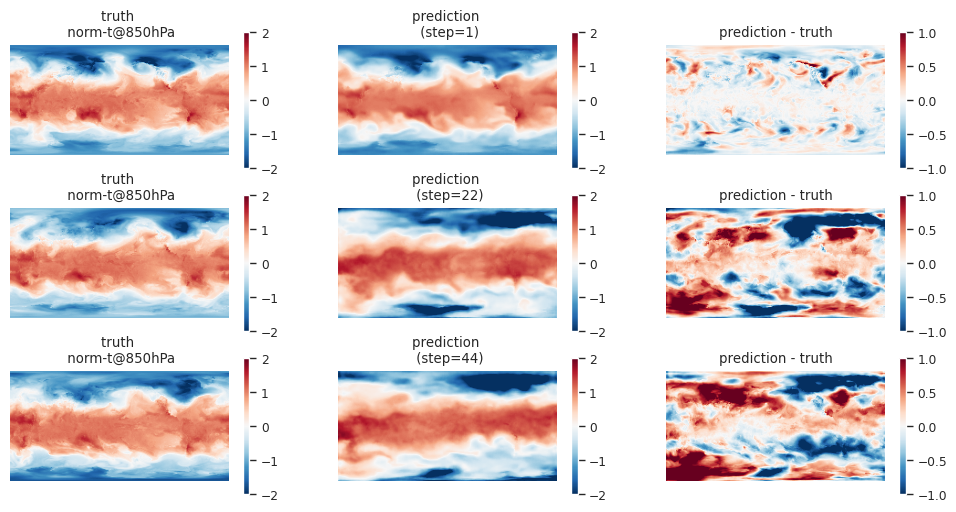

In [7]:
# Plotting
all_preds = np.array(all_preds)
all_truth = np.array(all_truth)

f, ax = plt.subplots(len(plot_idx), 3, figsize=(4 * len(plot_idx), 6))

for time_idx in range(len(plot_idx)):
    
    im0 = ax[time_idx, 0].imshow(all_truth[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    ax[time_idx, 0].set_title(f'truth \n norm-{param}@{level}hPa')
    ax[time_idx, 0].axis('off')
    cbar0 = f.colorbar(im0, ax=ax[time_idx, 0])

    im1 = ax[time_idx, 1].imshow(all_preds[time_idx], cmap='RdBu_r', vmin=-2, vmax=2)
    ax[time_idx, 1].set_title(f'prediction \n (step={plot_idx[time_idx]})')
    ax[time_idx, 1].axis('off')
    cbar1 = f.colorbar(im1, ax=ax[time_idx, 1])
    
    im2 = ax[time_idx, 2].imshow(all_preds[time_idx] - all_truth[time_idx], cmap='RdBu_r', vmin=-1, vmax=1)
    ax[time_idx, 2].set_title(f'prediction - truth')
    ax[time_idx, 2].axis('off')
    cbar2 = f.colorbar(im2, ax=ax[time_idx, 2])

plt.show();

## Energy spectrum

Processing unet/1-day
Processing unet/5-day
Processing resnet/1-day
Processing resnet/5-day
Processing ed/1-day
Processing ed/5-day


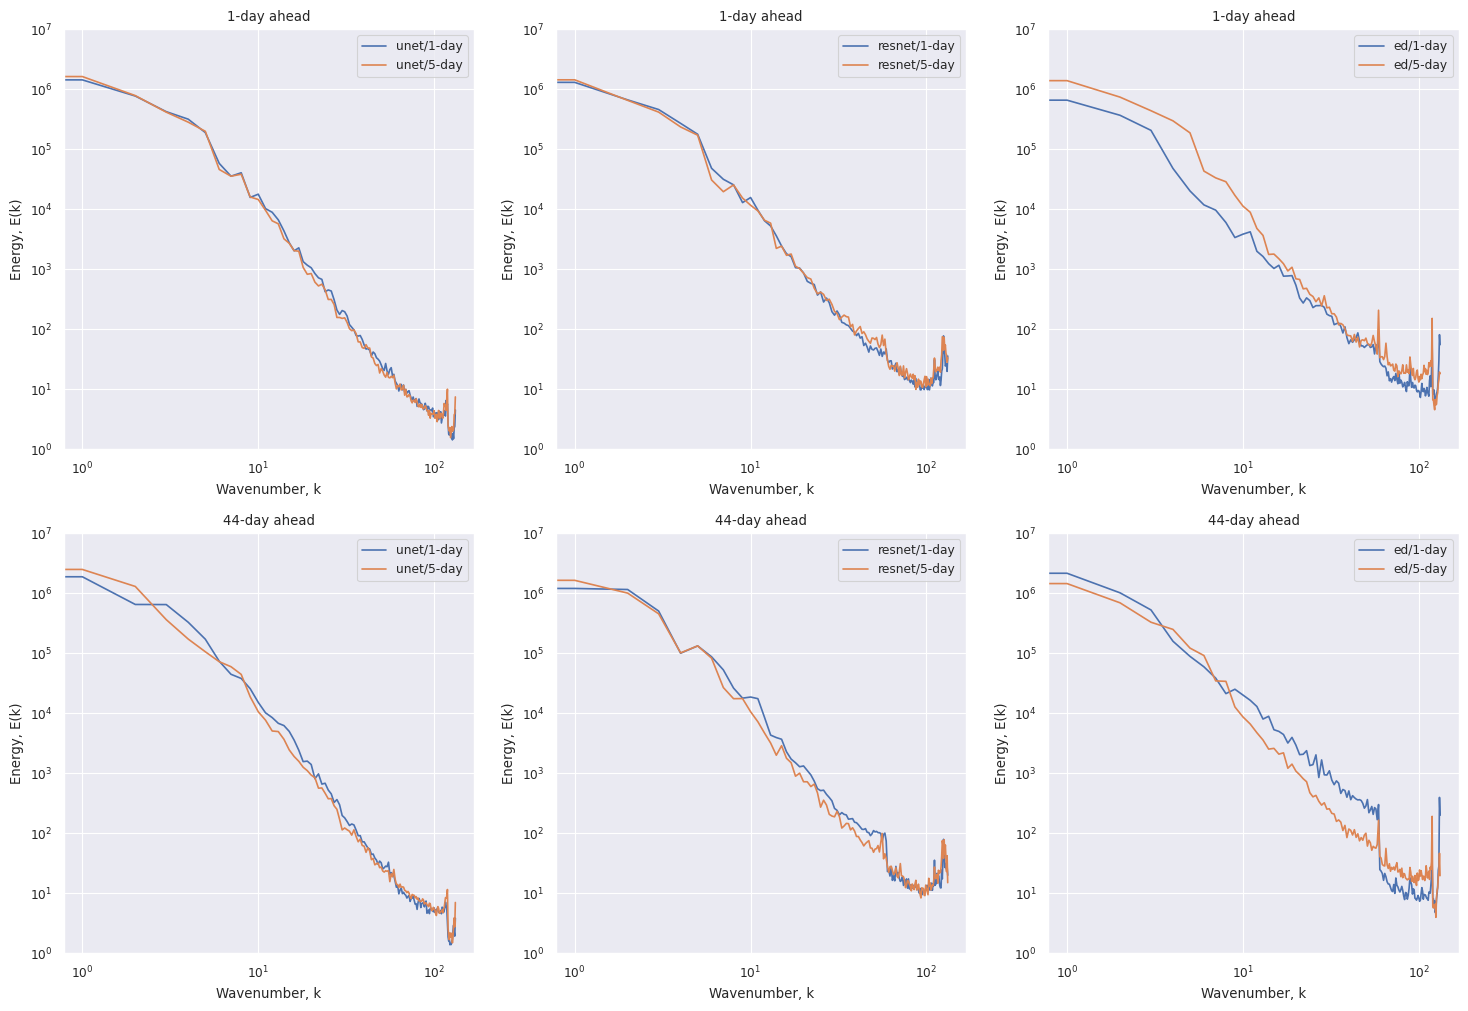

In [8]:
# First we set the hyperparameters
date_idx = 0
n_steps = [0, 43]
param = 't'
level = 850
all_Ek = dict()

model_list = [
    dict({'unet/1-day': 'unet_s2s/version_0', 'unet/5-day': 'unet_s2s/version_2'}),
    dict({'resnet/1-day': 'resnet_s2s/version_0', 'resnet/5-day': 'resnet_s2s/version_2'}),
    dict({'ed/1-day': 'ed_s2s/version_0', 'ed/5-day': 'ed_s2s/version_2'}),
]

## Initialize dataset
input_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)
output_dataset = dataset.S2SObsDataset(years=[2022], n_step=config.N_STEPS)

## For plotting
f, ax = plt.subplots(len(n_steps), len(model_list), figsize=(6*len(model_list), 6*len(n_steps)))

# Compute energy spectrum for each model and its configuration
for model_idx, model_item in enumerate(model_list):
    
    for _, (model_spec, model_name) in enumerate(model_item.items()):
        print(f'Processing {model_spec}')
        
        all_preds, all_truth = list(), list()
        
        model_basename, model_version = model_name.split('/')
        
        log_dir = Path('../logs') / model_basename
        model_config_filepath = Path(f'../chaosbench/configs/{model_basename}.yaml')

        with open(model_config_filepath, 'r') as config_filepath:
            hyperparams = yaml.load(config_filepath, Loader=yaml.FullLoader)

        model_args = hyperparams['model_args']
        data_args = hyperparams['data_args']

        # Load checkpoints
        ckpt_filepath = log_dir / f'lightning_logs/{model_version}/checkpoints/'
        ckpt_filepath = list(ckpt_filepath.glob('*.ckpt'))[0]
        baseline = model.S2SBenchmarkModel(model_args=model_args, data_args=data_args)
        baseline = baseline.load_from_checkpoint(ckpt_filepath)
        
        with torch.no_grad():
    
            timestamp, input_x, input_y = input_dataset[date_idx]
            _, output_x, output_y = output_dataset[date_idx]

            curr_x = input_x.unsqueeze(0).to(device)

            for step_idx in range(config.N_STEPS - 1):
                preds = baseline(curr_x)
                curr_y = output_y.unsqueeze(0)[:, step_idx + 1]

                all_preds.append(
                    preds[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy()
                )
                
                all_truth.append(
                    curr_y[0][config.PARAMS.index(param), config.PRESSURE_LEVELS.index(level)].detach().cpu().numpy()
                )

                curr_x = preds 
                
        all_preds, all_truth = np.array(all_preds), np.array(all_truth)
        
        
        # Plot energy spectrum
        curr_Ek = list()
        
        for step_idx in range(all_preds.shape[0]):
            pred_t = all_preds[step_idx]
            energy_t = np.fft.fft2(pred_t)
            energy_t = np.abs(energy_t)**2

            ny, nx = pred_t.shape
            kx = np.fft.fftfreq(nx) * nx
            ky = np.fft.fftfreq(ny) * ny

            kx, ky = np.meshgrid(kx, ky)
            k = np.sqrt(kx**2 + ky**2)

            k_bins = np.arange(0.5, np.max(k), 1)
            k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
            E_k = np.histogram(k, bins=k_bins, weights=energy_t)[0] / np.histogram(k, bins=k_bins)[0]
            curr_Ek.append(E_k)
            
            if step_idx in n_steps:
                step_num = n_steps.index(step_idx)
                ax[step_num, model_idx].set_title(f'{step_idx + 1}-day ahead')
                ax[step_num, model_idx].loglog(E_k, label=f'{model_spec}')
                ax[step_num, model_idx].set_xlabel('Wavenumber, k')
                ax[step_num, model_idx].set_ylabel('Energy, E(k)')
                ax[step_num, model_idx].set_ylim([10**0, 10**7])
                ax[step_num, model_idx].legend()
                
        all_Ek[model_spec] = np.array(curr_Ek)
                
plt.show()
        

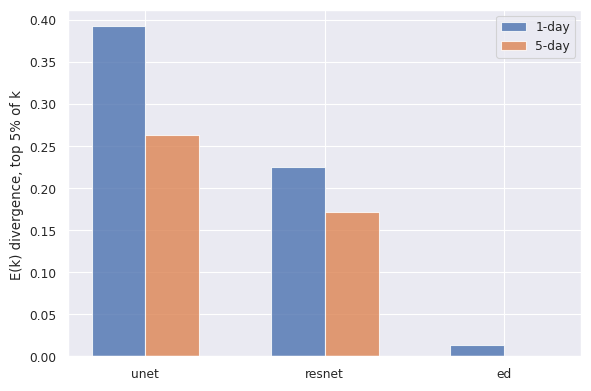

In [9]:
# Compute energy loss at different percentiles
Ek_divergence = dict()
percentile = 0.95

for model_idx, model_item in enumerate(model_list):
    model_divergence = list()
    
    for _, (model_spec, model_name) in enumerate(model_item.items()):
        model_name, days_ahead = model_spec.split('/')
        
        E_k = all_Ek[model_spec]
        percentile_idx = int(E_k.shape[-1] * percentile)

        Ek_decay = list()
        
        # Select only the 95th percentile energy along the wavenumber
        for i in range(1, E_k.shape[0]):
            Ek_decay.append(
                E_k[i, percentile_idx:].mean()
            )
        
        # Compute negative log convergence (similar to KL-divergence)
        model_divergence.append(-np.log(Ek_decay[-1] / max(Ek_decay)))
    
    Ek_divergence[model_name] = model_divergence
        
Ek_divergence = pd.DataFrame(Ek_divergence, index=[days.split('/')[-1] for days in list(model_item.keys())])
Ek_divergence = Ek_divergence.T


# Plotting
f, ax = plt.subplots(figsize=(6,4))
bar_width = 0.3
initial_positions = np.arange(len(Ek_divergence.index))

num_columns = len(Ek_divergence.columns)

# Loop through each column and plot the bars
for i, column in enumerate(Ek_divergence.columns):
    positions = initial_positions + i * bar_width
    ax.bar(positions, Ek_divergence[column], bar_width, label=column, alpha=0.8)

# Labeling and formatting
ax.set_ylabel(f'E(k) divergence, top {int((1-percentile)*100)}% of k ')
ax.set_xticks(initial_positions + bar_width * (num_columns - 1) / 2)
ax.set_xticklabels(Ek_divergence.index)
ax.legend()

plt.tight_layout()
plt.show()


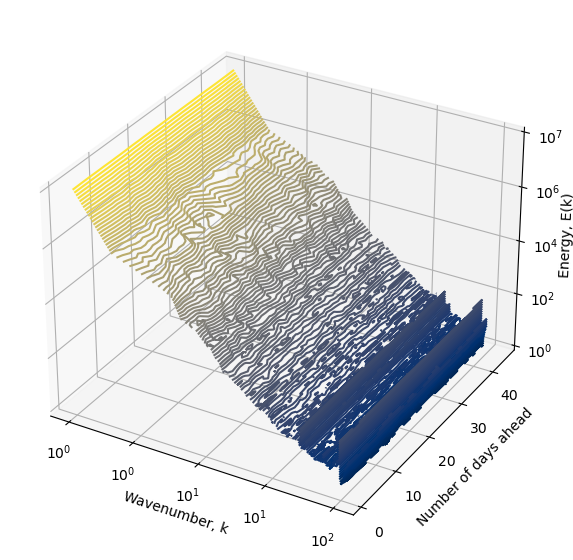

In [10]:
# Plot full Energy spectra
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def set_log_ticks_10_power(axis, num_ticks=5):
    lims = axis.get_data_interval()
    
    ticks = np.linspace(lims[0], lims[1], num=num_ticks)
    axis.set_ticks(ticks)
    axis.set_ticklabels([f'$10^{{{int(tick)}}}$' for tick in ticks])


f = plt.figure(figsize=(10, 7))
ax = f.add_subplot(111, projection='3d')
eps = 1e-50 # to void log(0)
all_Ek = list()

for n_step in range(all_preds.shape[0]):
    sample_data = all_preds[n_step]
    energy = np.fft.fft2(sample_data)
    energy = np.abs(energy)**2

    ny, nx = sample_data.shape
    kx = np.fft.fftfreq(nx) * nx
    ky = np.fft.fftfreq(ny) * ny

    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)

    k_bins = np.arange(0.5, np.max(k), 1)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    E_k = np.histogram(k, bins=k_bins, weights=energy)[0] / np.histogram(k, bins=k_bins)[0]
    all_Ek.append(E_k)
    
# Plot the 3D contour plot
all_Ek = np.array(all_Ek)
Wavenumber, Timestep = np.meshgrid(np.arange(1, all_Ek.shape[1] + 1), np.arange(1, all_Ek.shape[0] + 1))
contour = ax.contour3D(np.log10(Wavenumber + eps), Timestep, np.log10(all_Ek + eps), 100, cmap='cividis')

ax.set_xlabel('Wavenumber, k')
ax.set_ylabel('Number of days ahead')
ax.set_zlabel(r'Energy, E(k)', labelpad=0.1)

set_log_ticks_10_power(ax.xaxis)
set_log_ticks_10_power(ax.zaxis)

plt.show()

## Effects of temporal information

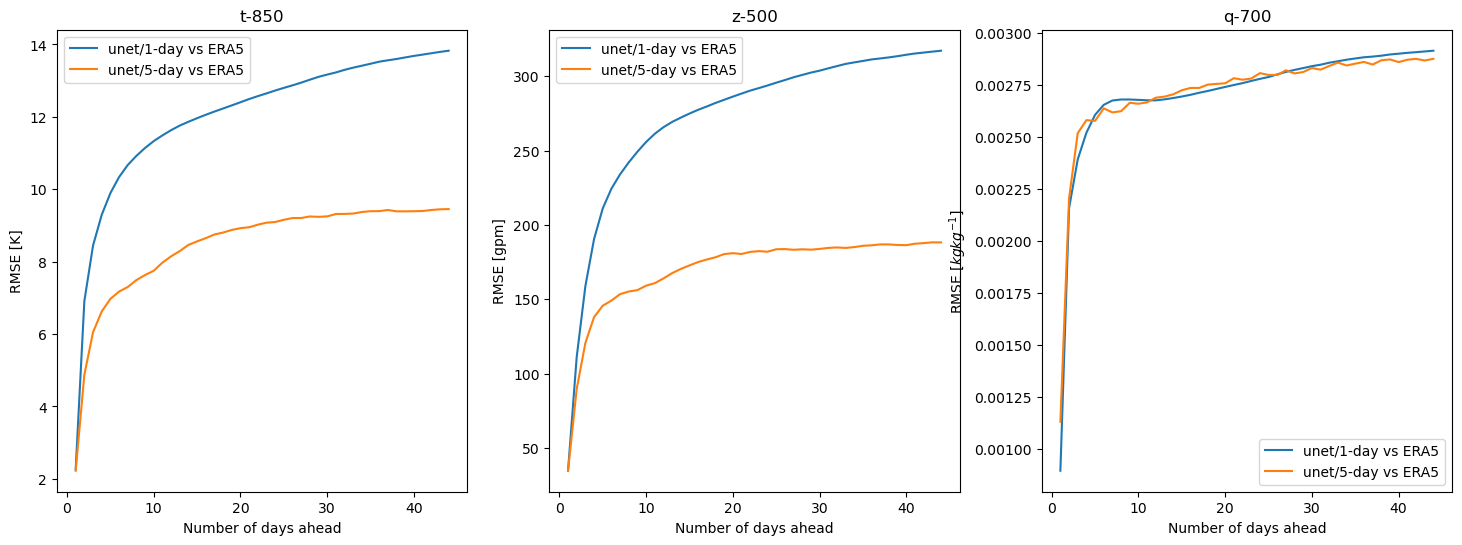

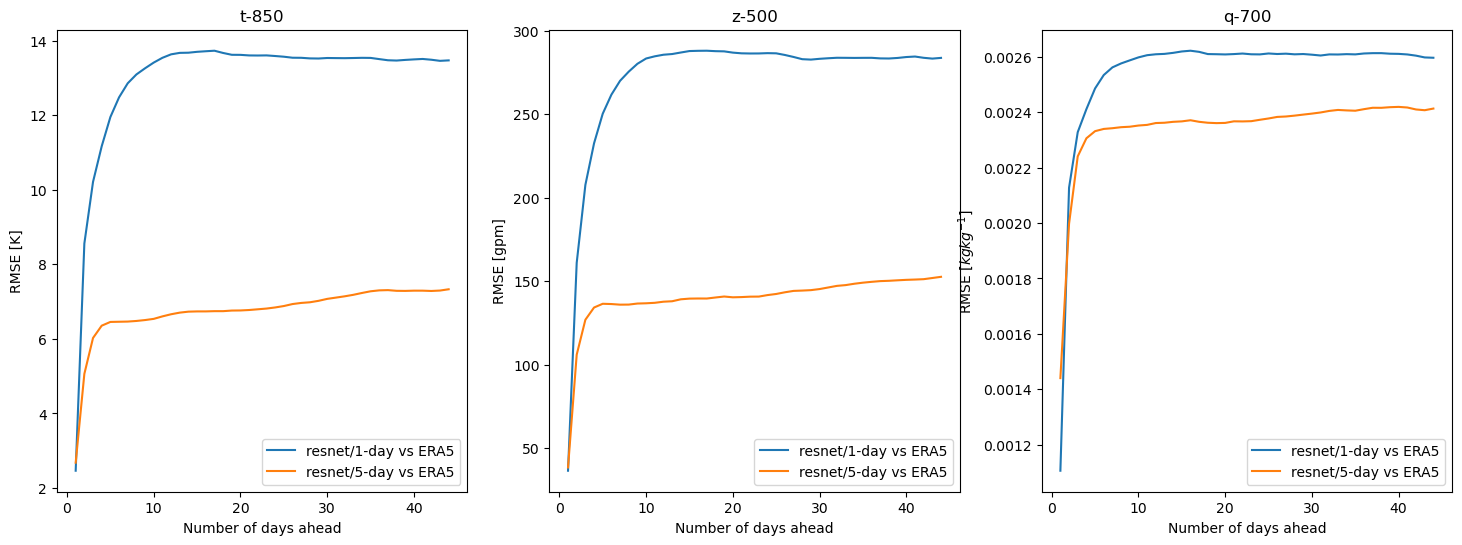

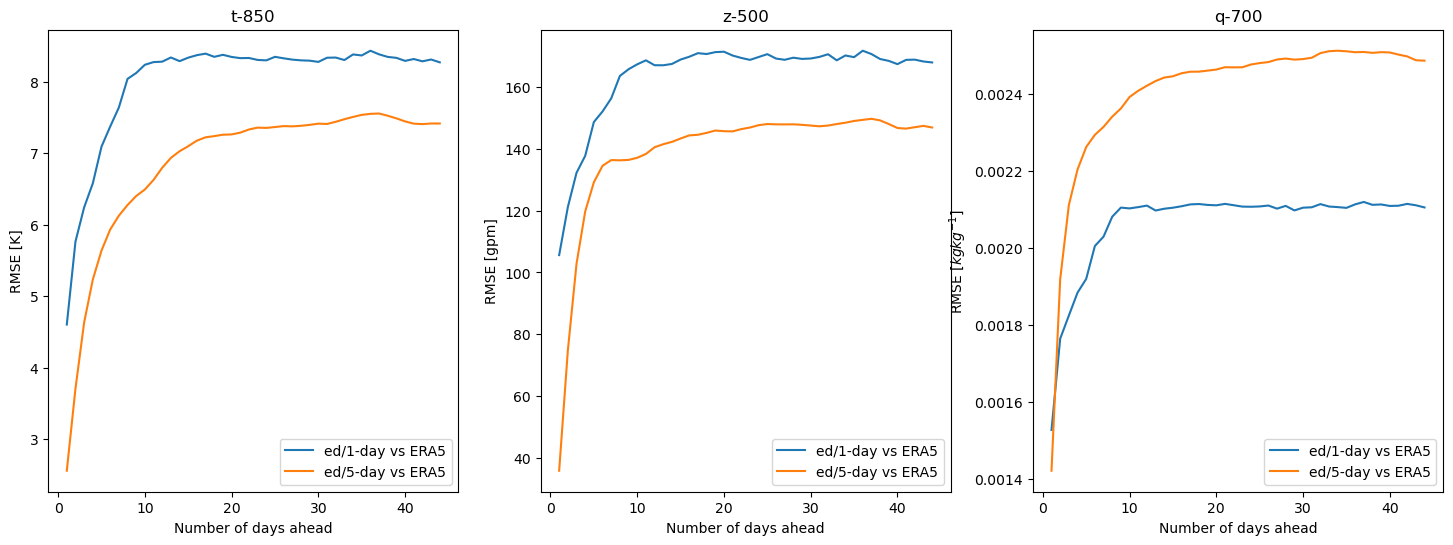

In [16]:
# Plot RMSE over time, across centers
for model_item in model_list:
    
    f, ax = plt.subplots(1, len(headline_vars), figsize=(6*len(headline_vars), 6))
    
    for model_idx, (model_spec, model_name) in enumerate(model_item.items()):
        
        model_basename, version_num = model_name.split('/')
        df = pd.read_csv(Path(f'../logs/{model_basename}/eval/{version_num}/rmse_{model_basename}.csv'))
        
        for headline_idx, (headline_var, headline_unit) in enumerate(headline_vars.items()):
            
            sns.lineplot(
                x=np.arange(1, df.shape[0]+1),
                y=df[[headline_var]].to_numpy().squeeze(), 
                label=f'{model_spec} vs ERA5',
                ax=ax[headline_idx]
            )
            
            ## Labeling
            ax[headline_idx].set_xlabel('Number of days ahead')
            ax[headline_idx].set_ylabel(f'RMSE [{headline_unit}]')
            ax[headline_idx].set_title(f'{headline_var}')
            
plt.show()